# Basic usage of the ``distoptica`` library #

## A NOTE BEFORE STARTING ##

Since the ``distoptica`` git repository tracks this notebook under its original
basename ``basic_usage.ipynb``, we recommend that you copy the original notebook
and rename it to any other basename that is not one of the original basenames
that appear in the ``<root>/examples`` directory before executing any of the
notebook cells below, where ``<root>`` is the root of the ``distoptica``
repository. This way you can explore the notebook by executing and modifying
cells without changing the original notebook, which is being tracked by git.

## Table of contents ##

- [Import necessary modules](#Import-necessary-modules)
- [Introduction](#Introduction)
- [Using the ``distoptica`` library](#Using-the-distoptica-library)
  - [Creating an undistorted image set](#Creating-an-undistorted-image-set)
  - [Specifying the distortion model](#Specifying-the-distortion-model)
  - [Visualizing the convergence of the least-squares algorithm](#Visualizing-the-convergence-of-the-least-squares-algorithm)
  - [Visualizing the flow fields](#Visualizing-the-flow-fields)
  - [Distorting then resampling images](#Distorting-then-resampling-images)
  - [Undistorting then resampling images](#Undistorting-then-resampling-images)
  - [Applying the coordinate transformation directly](#Applying-the-coordinate-transformation-directly)

## Import necessary modules ##

In [1]:
# For general array handling.
import numpy as np
import torch

# For closing figures.
import matplotlib.pyplot as plt



# The library that is the subject of this demonstration.
import distoptica

# For generating and visualizing data to be used in this demonstration. Users
# need not focus on the implementation details of this module in order to follow
# the logic of each cell in the remainder of this notebook. Morevoer, users need
# not import this module for their own applications of ``distoptica``.
import helpers_for_basic_usage as helpers

## Introduction ##

In this notebook, we demonstrate how one can use each function and class in the
``distoptica`` library.

In order to execute the cells in this notebook as intended, a set of Python
libraries need to be installed in the Python environment within which the cells
of the notebook are to be executed. For this particular notebook, users need to
install:

    torch
    hyperspy
    numba
    jupyter
    ipympl
    distoptica

Before installing `distoptica`, it is recommended that users install `torch`
(i.e. `PyTorch`) in the same environment that they intend to install
`distoptica` according to the instructions given
[here](https://pytorch.org/get-started/locally/) for their preferred `PyTorch`
installation option. After installing `torch`, users can install the remaining
libraries either via `pip`:

    pip install distoptica[examples]

or `conda`:

    conda install -y distoptica jupyter ipympl hyperspy numba -c conda-forge

You can find the documentation for the `distoptica` library
[here](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.html). It
is recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them. **Users should make sure to navigate the
documentation for the version of `distoptica` that they are currently using.**

The last module that we imported above (i.e. the module with the alias
`helpers`) contains helper functions that are used throughout the remainder of
the notebook, specifically to generate and visualize data. It is not essential
that users know the implementation details of these helper functions in order to
follow the logic of each cell in the remainder of this notebook. Moreover, users
need not import this module for their own applications of `distoptica`. That
being said, if any users are interested in the implementation details, they can
find them in the file `<root>/examples/helpers_for_basic_usage.py`.

## Using the ``distoptica`` library ##

### Creating an undistorted image set ###

Let's create a 2D ``hyperspy`` signal that stores a set of undistorted images
that we will distort then resample below, and then subsequently undistort then
resample to recover approximately the original image set:

In [2]:
undistorted_image_set_signal = helpers.generate_undistorted_image_set_signal()

Let's visualize the undistorted image set that we just created.

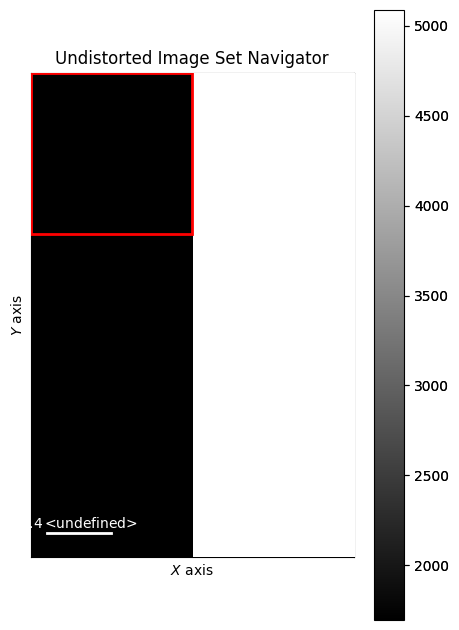

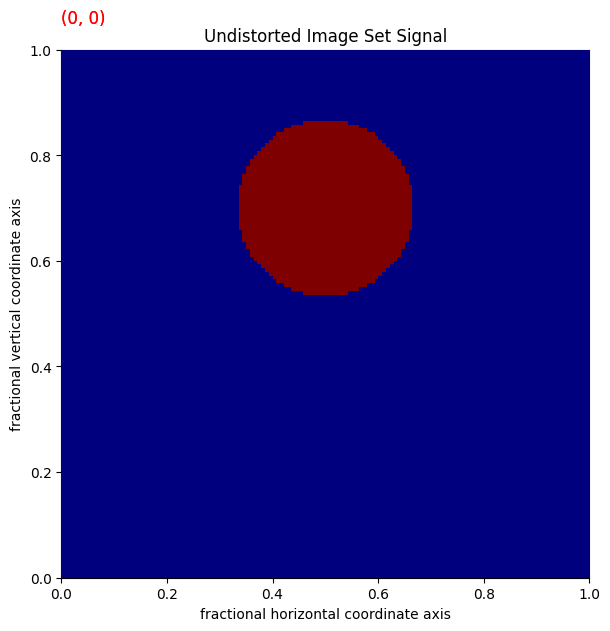

In [3]:
%matplotlib ipympl

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
undistorted_image_set_signal.plot(**kwargs)

### Specifying the distortion model ###

In order to distort and/or undistort images, we need to specify a distortion
model. This entails specifying several sets of parameters.

First, we need to specify the coordinate transformation that maps fractional
coordinates of an undistorted image to those of the corresponding distorted
image of interest. See
[here](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.CoordTransformParams.html)
for a detailed description of the mathematical form of the coordinate
transformation, and the parameters required to specify an instance of such a
coordinate transformation. In short, we need to specify the distortion center,
and four coefficient matrices: the radial cosine, the radial sine, the
tangential cosine, and the tangential sine coefficient matrices. In this
demonstration, we will chose coefficient matrices corresponding to a distortion
field that is a combination of elliptical, quadratic radial, parabolic, and
spiral distortion:

In [4]:
center = (0.52, 0.49)

quadratic_radial_distortion_amplitude = -0.4

spiral_distortion_amplitude = 0.1

amplitude = 0.07
phase = 7*np.pi/8
elliptical_distortion_vector = (amplitude*np.cos(2*phase).item(), 
                                amplitude*np.sin(2*phase).item())

amplitude = 0.1
phase = 4*np.pi/3
parabolic_distortion_vector = (amplitude*np.cos(phase), 
                               amplitude*np.sin(phase))



A_r_0_2 = quadratic_radial_distortion_amplitude
A_r_1_1 = parabolic_distortion_vector[0]
A_r_2_0 = elliptical_distortion_vector[0]

radial_cosine_coefficient_matrix = ((0.00000, 0.00000, A_r_0_2),
                                    (0.00000, A_r_1_1, 0.00000),
                                    (A_r_2_0, 0.00000, 0.00000))



B_r_0_1 = parabolic_distortion_vector[1]
B_r_1_0 = elliptical_distortion_vector[1]

radial_sine_coefficient_matrix = ((0.00000, B_r_0_1),
                                  (B_r_1_0, 0.00000))


    
A_t_0_2 = spiral_distortion_amplitude
A_t_1_1 = B_r_0_1 / 3
A_t_2_0 = B_r_1_0

tangential_cosine_coefficient_matrix = ((0.00000, 0.00000, A_t_0_2),
                                        (0.00000, A_t_1_1, 0.00000),
                                        (A_t_2_0, 0.00000, 0.00000))


    
B_t_0_1 = -A_r_1_1 / 3
B_t_1_0 = -A_r_2_0

tangential_sine_coefficient_matrix = ((0.00000, B_t_0_1),
                                      (B_t_1_0, 0.00000))



kwargs = {"center": \
          center,
          "radial_cosine_coefficient_matrix": \
          radial_cosine_coefficient_matrix,
          "radial_sine_coefficient_matrix": \
          radial_sine_coefficient_matrix, 
          "tangential_cosine_coefficient_matrix": \
          tangential_cosine_coefficient_matrix,
          "tangential_sine_coefficient_matrix": \
          tangential_sine_coefficient_matrix}
coord_transform_params = distoptica.CoordTransformParams(**kwargs)

Note that the class ``distoptica.CoordTransformParams`` is a subclass of
``fancytypes.PreSerializableAndUpdatable``, meaning that it is a type that is
pre-serializable, that can be constructed from a serializable representation,
and that has an updatable subset of attributes. See
[here](https://mrfitzpa.github.io/fancytypes/_autosummary/fancytypes.PreSerializableAndUpdatable.html)
for a definition of pre-serialization, and the documentation for all the
attributes and methods associated with the class
``fancytypes.PreSerializableAndUpdatable``.

Next, we must specify the parameters of the least-squares algorithm to be used
to calculate the right-inverse of the coordinate transformation. See
[here](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.LeastSquaresAlgParams.html)
for a discussion on the algorithm and a description of the algorithm's
parameters. The values we use for the parameters below should work for most
scenarios.

In [5]:
kwargs = {"max_num_iterations": 20,
          "initial_damping": 1e-3,
          "factor_for_decreasing_damping": 9,
          "factor_for_increasing_damping": 11,
          "improvement_tol": 0.1, 
          "rel_err_tol": 1e-2, 
          "plateau_tol": 1e-3, 
          "plateau_patience": 2, 
          "skip_validation_and_conversion": False}
least_squares_alg_params = distoptica.LeastSquaresAlgParams(**kwargs)

Note that the class ``distoptica.LeastSquaresAlgParams`` is also a subclass of
``fancytypes.PreSerializableAndUpdatable``.

Next, we must specify the sampling grid dimensions, in units of pixels. Upon
distorting or undistorting an image set, the transformed image set is resampled
at a resolution determined by the sampling grid dimensions. See the summary
documentation of the class ``distoptica.DistortionModel``
[here](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.DistortionModel.html),
wherein there is a full discussion on how image transformation, and subsequent
resampling is performed.

In [6]:
sampling_grid_dims_in_pixels = (200,  # Number of columns.
                                200)  # Number of rows.

And lastly, we specify the device to be used to perform computationally
intensive calls to PyTorch functions and where to store attributes of the type
``torch.Tensor``:

In [7]:
device_name = "cpu"

Putting all the parameters together, we construct our distortion model:

In [8]:
kwargs = {"coord_transform_params": coord_transform_params,
          "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels,
          "device_name": device_name,
          "least_squares_alg_params": least_squares_alg_params}
distortion_model = distoptica.DistortionModel(**kwargs)

Note that the class ``distoptica.DistortionModel`` is also a subclass of
``fancytypes.PreSerializableAndUpdatable``.

One can check whether the distortion model is azimuthally symmetric:

In [9]:
distortion_model.is_azimuthally_symmetric

False

An example of a distortion model that is azimuthally symmetric is one that
possesses only quadratic radial distortion.

One can also check whether the distortion model is trivial, i.e. that the
corresponding coordinate transformation is equivalent to the identity
transformation:

In [10]:
distortion_model.is_trivial

False

One can also check whether the distortion model is "standard". We define a
standard distortion model as one that possesses any combination of elliptical,
quadratic radial, parabolic, and spiral distortion.

In [11]:
distortion_model.is_standard

True

Evidently, the distortion model that we have constructed is standard. See
[here](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.StandardCoordTransformParams.html)
for a discussion on the mathematical form of the coordinate transformations that
correspond to standard distortion models.

Note that we can get the same information from the object
``coord_transform_params``, which we used to construct the distortion model:

In [12]:
coord_transform_params.is_corresponding_model_azimuthally_symmetric

False

In [13]:
coord_transform_params.is_corresponding_model_trivial

False

In [14]:
coord_transform_params.is_corresponding_model_standard

True

``distoptica`` offers a more convenient way to construct standard distortion
models. First, we need to specify the "standard" coordinate transformation
parameters:

In [15]:
kwargs = \
    {"center": \
     center,
     "quadratic_radial_distortion_amplitude": \
     quadratic_radial_distortion_amplitude,
     "elliptical_distortion_vector": \
     elliptical_distortion_vector,
     "spiral_distortion_amplitude": \
     spiral_distortion_amplitude,
     "parabolic_distortion_vector": \
     parabolic_distortion_vector}
standard_coord_transform_params = \
    distoptica.StandardCoordTransformParams(**kwargs)

Note that the class ``distoptica.StandardCoordTransformParams`` is also a
subclass of ``fancytypes.PreSerializableAndUpdatable``. Moreover, using the
instance of this class that we have just constructed, we can also determine
whether the corresponding distortion model is azimuthally symmetric, and whether
it is trivial:

In [16]:
standard_coord_transform_params.is_corresponding_model_azimuthally_symmetric

False

In [17]:
standard_coord_transform_params.is_corresponding_model_trivial

False

After constructing the instance of the class
``distoptica.StandardCoordTransformParams``, we can construct the same
distortion model as before in a similar manner:

In [18]:
kwargs = {"coord_transform_params": standard_coord_transform_params,
          "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels,
          "device_name": device_name,
          "least_squares_alg_params": least_squares_alg_params}
distortion_model = distoptica.DistortionModel(**kwargs)

Alternatively, we can use the function
``distoptica.generate_standard_distortion_model`` to construct the same
distortion model as before:

In [19]:
kwargs = {"standard_coord_transform_params": standard_coord_transform_params,
          "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels,
          "device_name": device_name,
          "least_squares_alg_params": least_squares_alg_params}
distortion_model = distoptica.generate_standard_distortion_model(**kwargs)

As a side note, users can also convert
``distoptica.StandardCoordTransformParams`` objects to
``distoptica.CoordTransformParams`` objects as follows:

In [20]:
kwargs = \
    {"standard_coord_transform_params": standard_coord_transform_params}
coord_transform_params = \
    distoptica.from_standard_to_generic_coord_transform_params(**kwargs)

where ``standard_coord_transform_params`` and ``coord_transform_params`` specify
the same coordinate transformation.

### Visualizing the convergence of the least-squares algorithm ###

The distortion model that we have just constructed, ``distortion_model``,
samples the flow fields of both the corresponding coordinate transformation, and
its right-inverse, and stores the sampled flow fields as attributes. Recall from
the discussion above that a least-squares algorithm is employed to calculate the
sampled right-inverse of the coordinate transformation, and thus the
corresponding flow field as well. In general, the right-inverse of the
coordinate transformation will not be necessarily well-defined for all points on
the sampling grid, which means that the least-squares algorithm will not
converge for such points. A map of the convergence is stored in the attribute
``convergence_map_of_distorted_then_resampled_images``. Let's visualize this
convergence map.

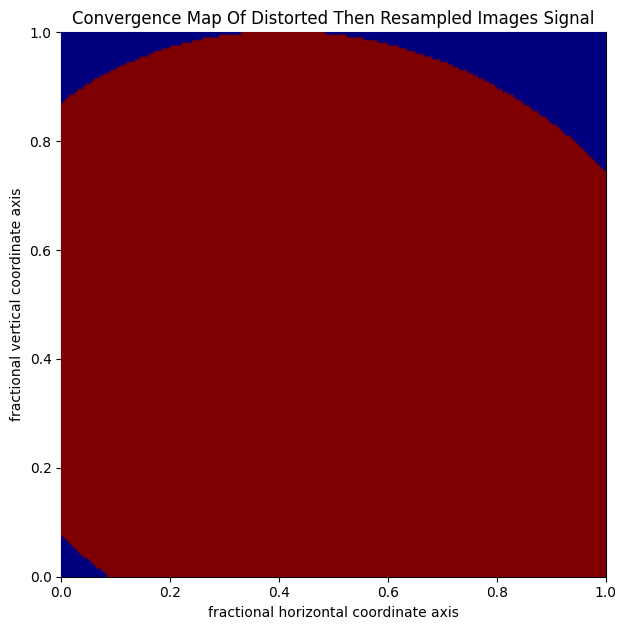

In [21]:
attr_name = "convergence_map_of_distorted_then_resampled_images"
convergence_map = getattr(distortion_model, attr_name)

kwargs = {"torch_tensor": convergence_map, 
          "title": "Convergence Map Of Distorted Then Resampled Images"}
convergence_map_signal = helpers.convert_torch_tensor_to_signal(**kwargs)



%matplotlib inline

plt.close("all")  # Close all previous figures to release memory.

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
convergence_map_signal.plot(**kwargs)

From this convergence map, we can conclude that either the calculation of the
flow field of the right-inverse of the coordinate transformation is not
accurate, or that the right-inverse is not well-defined, at the sampling points
in the blue regions. For the flow field of the right-inverse of the coordinate
transformation, or for images that have been distorted according to the
distortion model, users may want to mask the pixels corresponding to the blue
regions prior to performing any subsequent operations on said flow fields or
distorted images. Alternatively, if users prefer to use a rectangular mask,
distortion models also store as an attribute the specifications of the minimum
frame to mask all boolean values of ``False`` in the aforementioned convergence
map. The specifications of this mask frame are stored in the attribute
``mask_frame_of_distorted_then_resampled_images``. Let's visualize the mask
frame.

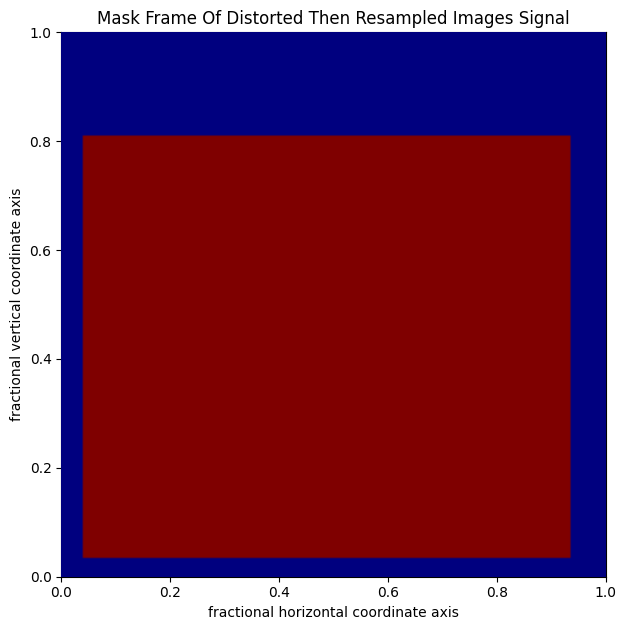

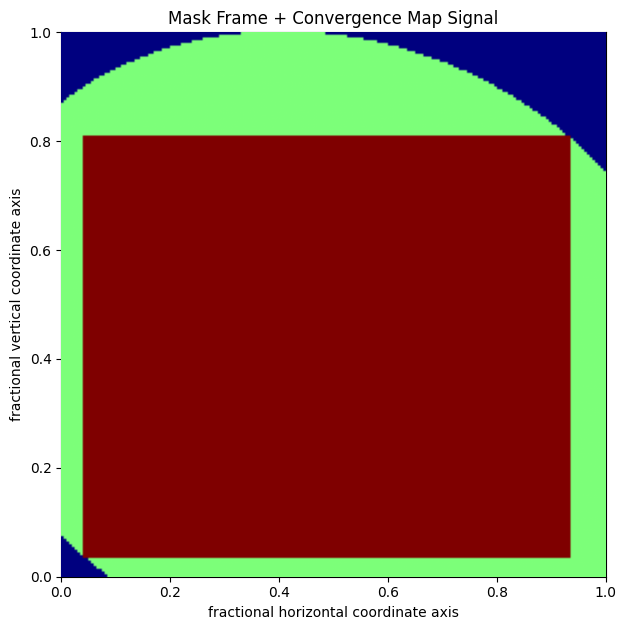

In [22]:
attr_name = "mask_frame_of_distorted_then_resampled_images"
mask_frame = getattr(distortion_model, attr_name)

L = mask_frame[0]  # Width in units of pixels of left side of mask frame.
R = mask_frame[1]  # Width in units of pixels of right side of mask frame.
B = mask_frame[2]  # Width in units of pixels of bottom side of mask frame.
T = mask_frame[3]  # Width in units of pixels of top side of mask frame.

v_dim, h_dim = convergence_map.shape

mask = torch.ones_like(convergence_map)
mask[:T, :] = 0
mask[v_dim-B:, :] = 0
mask[:, :L] = 0
mask[:, h_dim-R:] = 0

kwargs = {"torch_tensor": mask, 
          "title": "Mask Frame Of Distorted Then Resampled Images"}
mask_signal = helpers.convert_torch_tensor_to_signal(**kwargs)



kwargs = \
    {"torch_tensor": 1.0*mask+1.0*convergence_map, 
     "title": "Mask Frame + Convergence Map"}
mask_plus_convergence_map_signal = \
    helpers.convert_torch_tensor_to_signal(**kwargs)



kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
mask_signal.plot(**kwargs)



kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
mask_plus_convergence_map_signal.plot(**kwargs)

### Visualizing the flow fields ###

Let's now visualize the flow fields of both the coordinate transformation, and
its right-inverse, however let's visualize only the flow field vectors at every
8th row and column of the sampling grid. To visualize the flow fields, we make
use of the attributes ``sampling_grid``, ``flow_field_of_coord_transform``, and
``flow_field_of_coord_transform_right_inverse``.

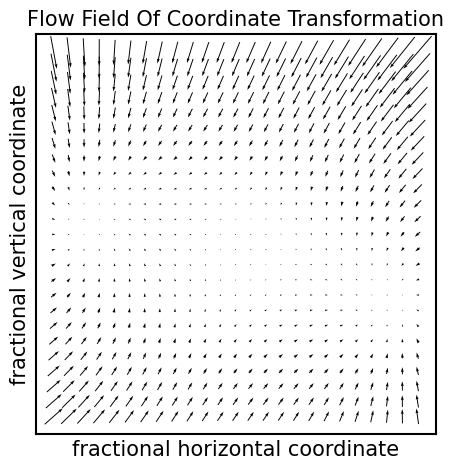

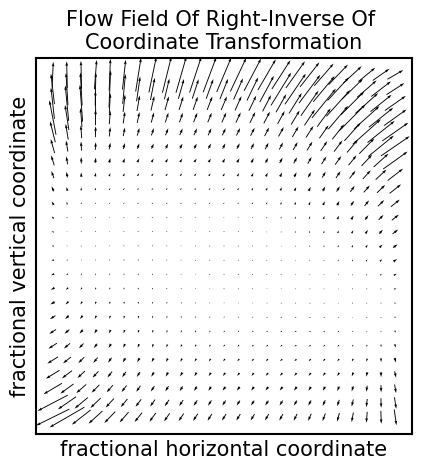

In [23]:
kwargs = {"sampling_grid": \
          distortion_model.sampling_grid,
          "flow_field": \
          distortion_model.flow_field_of_coord_transform, 
          "title": \
          "Flow Field Of Coordinate Transformation"}
helpers.visualize_flow_field(**kwargs)

kwargs = {"sampling_grid": \
          distortion_model.sampling_grid,
          "flow_field": \
          distortion_model.flow_field_of_coord_transform_right_inverse, 
          "title": \
          "Flow Field Of Right-Inverse Of \nCoordinate Transformation"}
helpers.visualize_flow_field(**kwargs)

### Distorting then resampling images ###

Now let's distort then resample our original undistorted image set using the
method ``distort_then_resample_images``. See
[here](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.DistortionModel.html#distoptica.DistortionModel.distort_then_resample_images)
for a full discussion on the expected input and the resulting output.

In [24]:
method_alias = distortion_model.distort_then_resample_images
kwargs = {"undistorted_images": undistorted_image_set_signal.data}
distorted_then_resampled_image_set = method_alias(**kwargs)

Let's visualize the distorted then resampled image set that we just created.

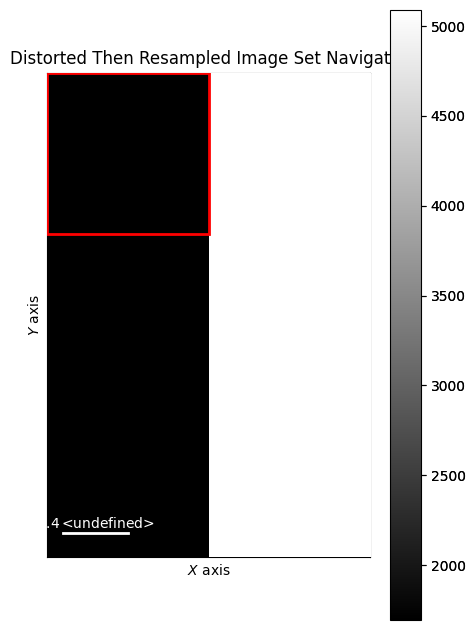

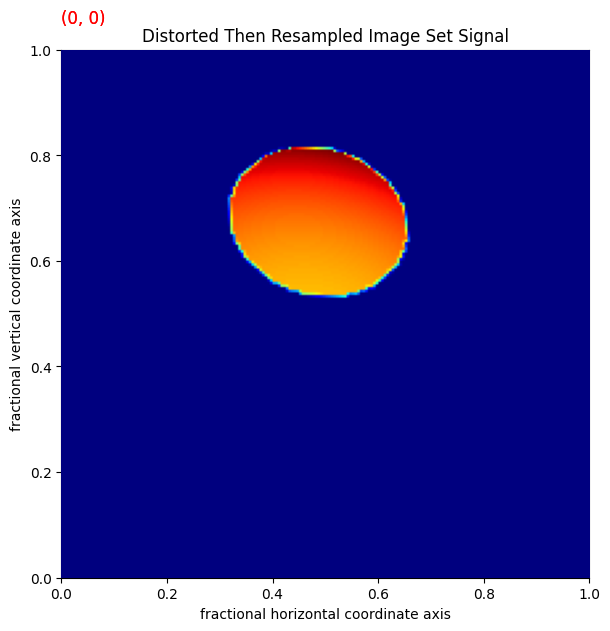

In [25]:
func_alias = helpers.convert_torch_tensor_to_signal
kwargs = {"torch_tensor": distorted_then_resampled_image_set, 
          "title": "Distorted Then Resampled Image Set"}
distorted_then_resampled_image_set_signal = func_alias(**kwargs)



%matplotlib ipympl

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
distorted_then_resampled_image_set_signal.plot(**kwargs)

One can also visualize the out-of-bounds map of distorted then resampled images.

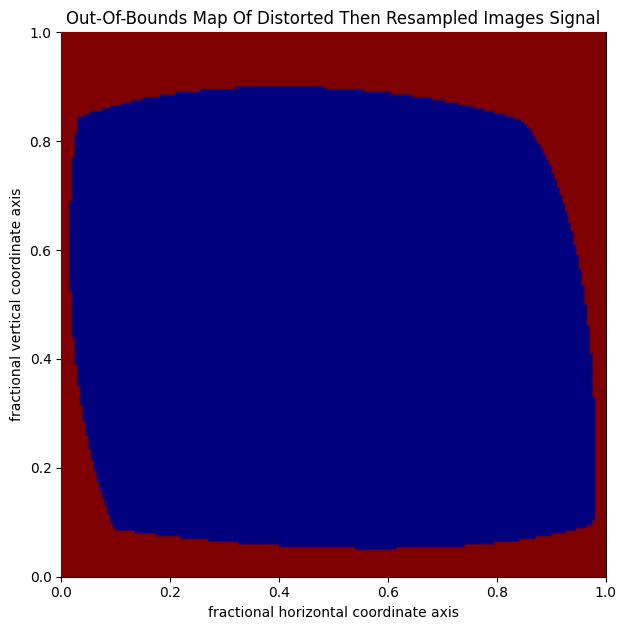

In [26]:
out_of_bounds_map = \
    distortion_model.out_of_bounds_map_of_distorted_then_resampled_images

func_alias = helpers.convert_torch_tensor_to_signal
kwargs = {"torch_tensor": out_of_bounds_map, 
          "title": "Out-Of-Bounds Map Of Distorted Then Resampled Images"}
out_of_bounds_map_signal = func_alias(**kwargs)



%matplotlib inline

plt.close("all")  # Close all previous figures to release memory.

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
out_of_bounds_map_signal.plot(**kwargs)

### Undistorting then resampling images ###

Let's undistort the distorted image set that we created above using the method
``undistort_then_resample_images``. See
[here](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.DistortionModel.html#distoptica.DistortionModel.undistort_then_resample_images)
for a full discussion on the expected input and the resulting output.

In [27]:
method_alias = distortion_model.undistort_then_resample_images
kwargs = {"distorted_images": distorted_then_resampled_image_set_signal.data}
distortion_corrected_image_set = method_alias(**kwargs)

Let's visualize the distortion-corrected image set and juxtapose it to the
original undistorted image set.

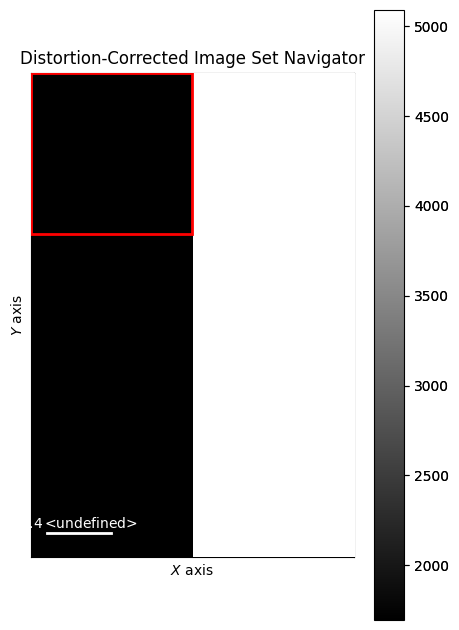

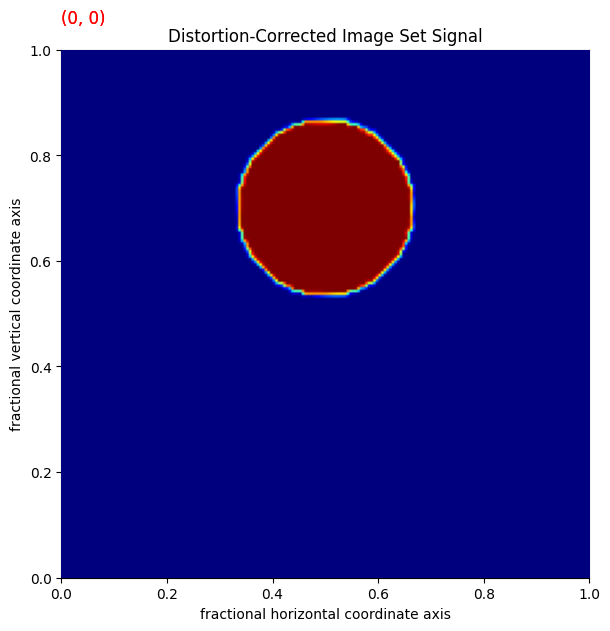

In [28]:
func_alias = helpers.convert_torch_tensor_to_signal
kwargs = {"torch_tensor": distortion_corrected_image_set, 
          "title": "Distortion-Corrected Image Set"}
distortion_corrected_image_set_signal = func_alias(**kwargs)



%matplotlib ipympl

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
distortion_corrected_image_set_signal.plot(**kwargs)

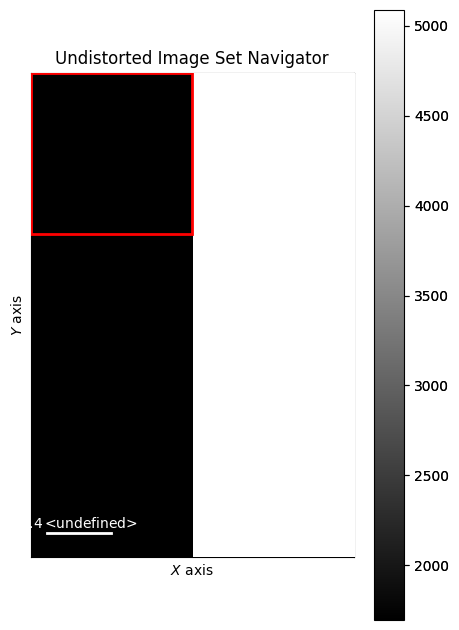

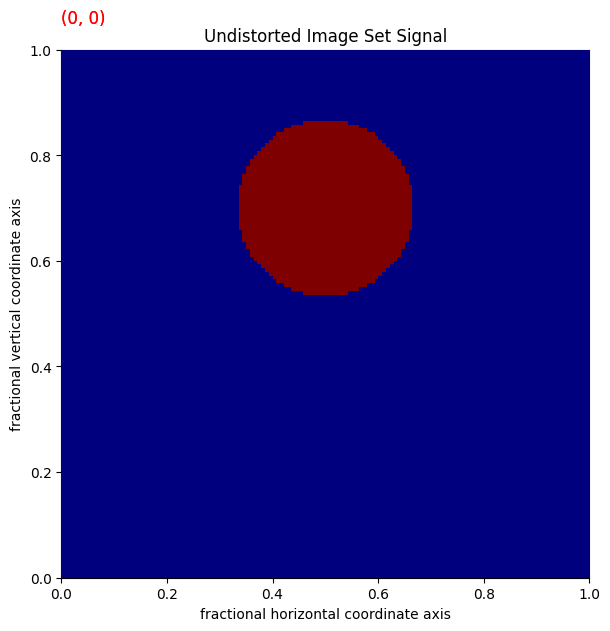

In [29]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
undistorted_image_set_signal.plot(**kwargs)

Note that the pixel values are different between the signals because the first
signal is a result of resampling, i.e. it contains more pixels. For each image
in the first signal, the sum of all pixels is approximately equal to that in the
corresponding image in the second signal, as expected.

In [30]:
print("Pixel sums in first signal:")
print(distortion_corrected_image_set_signal.data.sum(axis=(2, 3)))

print()

print("Pixel sums in second signal:")
print(undistorted_image_set_signal.data.sum(axis=(2, 3)))

Pixel sums in first signal:
[[1696.6543 5089.963 ]
 [1696.0803 5088.241 ]
 [1695.4597 5086.38  ]]

Pixel sums in second signal:
[[1696. 5088.]
 [1696. 5088.]
 [1696. 5088.]]


Lastly, let's visualize the out-of-bounds map of undistorted then resampled
images.

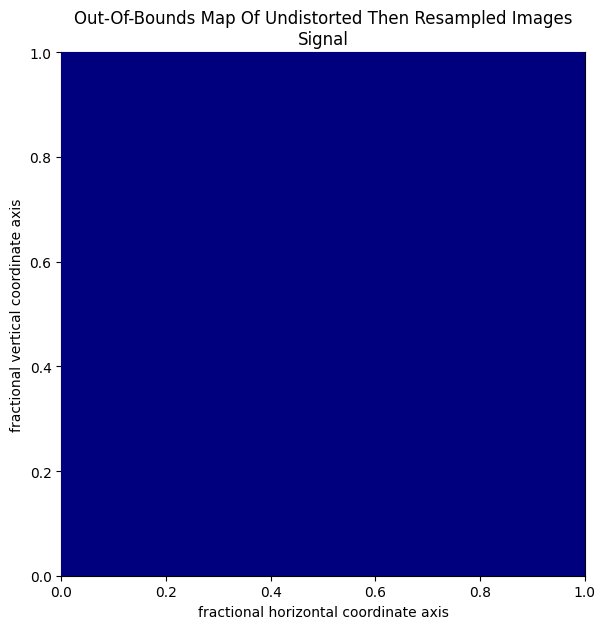

In [31]:
out_of_bounds_map = \
    distortion_model.out_of_bounds_map_of_undistorted_then_resampled_images

func_alias = helpers.convert_torch_tensor_to_signal
kwargs = {"torch_tensor": out_of_bounds_map, 
          "title": "Out-Of-Bounds Map Of Undistorted Then Resampled Images"}
out_of_bounds_map_signal = func_alias(**kwargs)



%matplotlib inline

plt.close("all")  # Close all previous figures to release memory.

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 1,
          "cmap": "jet"}
out_of_bounds_map_signal.plot(**kwargs)

### Applying the coordinate transformation directly ###

Using the coordinate transformation parameters in conjunction with the function
``distoptica.apply_coord_transform``, we can apply directly the coordinate
transformation to a set of coordinates of points in an undistorted image:

In [32]:
# ``u_x`` and ``u_y`` together store the fractional coordinates of points in an
# undistorted image.
u_x = torch.tensor([[0.35, 0.50, 0.65],
                    [0.35, 0.50, 0.65]])
u_y = torch.tensor([[0.35, 0.35, 0.35],
                    [0.35, 0.35, 0.35]])

kwargs = {"u_x": u_x,
          "u_y": u_y,
          "coord_transform_params": coord_transform_params}
q_x, q_y = distoptica.apply_coord_transform(**kwargs)

print("q_x:")
print(q_x)

print()

print("q_y:")
print(q_y)

q_x:
tensor([[0.3493, 0.5059, 0.6619],
        [0.3493, 0.5059, 0.6619]], grad_fn=<UnbindBackward0>)

q_y:
tensor([[0.3639, 0.3572, 0.3514],
        [0.3639, 0.3572, 0.3514]], grad_fn=<UnbindBackward0>)


Similarly, we can apply the right inverse of the coordinate transformation:

In [33]:
kwargs = \
    {"q_x": q_x,
     "q_y": q_y,
     "coord_transform_params": coord_transform_params, 
     "least_squares_alg_params": least_squares_alg_params}
u_x, u_y, convergence_map = \
    distoptica.apply_coord_transform_right_inverse(**kwargs)

print("u_x:")
print(u_x)

print()

print("u_y:")
print(u_y)

print()

print("convergence_map:")
print(convergence_map)

u_x:
tensor([[0.3500, 0.5000, 0.6500],
        [0.3500, 0.5000, 0.6500]], grad_fn=<UnbindBackward0>)

u_y:
tensor([[0.3500, 0.3500, 0.3500],
        [0.3500, 0.3500, 0.3500]], grad_fn=<UnbindBackward0>)

convergence_map:
tensor([[True, True, True],
        [True, True, True]])


The tensor ``convergence_map`` stores the convergence map of the iterative
algorithm used to apply the right inverse of the coordinate transformation. As
we can see, for this example, the iterative algorithm converges for all
coordinates.